In [1]:
#Importing the librairies

import os
import tarfile
import urllib

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

#Only for jupyter notebooks
%matplotlib inline

In [2]:
from sklearn.datasets import fetch_openml

In [3]:
mnist = fetch_openml("mnist_784",version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
print(mnist["DESCR"])

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [5]:
X, y = mnist["data"], mnist["target"]

In [6]:
X.shape #Number of rows and number of features.

(70000, 784)

Here, the number of features, 784, correspond to each image that is a 28 x 28 pixels.

In [7]:
y.shape #Number of rows, the label of each picture

(70000,)

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [9]:
random_digit = X[0]
random_digit_image = random_digit.reshape(28,28) #Reshaping the image to be seen with matplotlib.

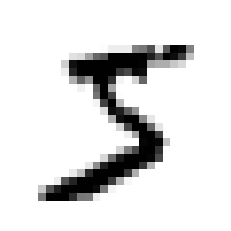

In [10]:
plt.imshow(random_digit_image,cmap="binary")
plt.axis("off")
plt.show()

In [11]:
#Comparing to the label
y[0]

'5'

In [12]:
#And because our ML algorithm expect an int value and no a str value as label, we change it.
y = y.astype(np.int)

In [13]:
#Since the dataset is already split and shuffled for us, we can split it easily without using a stratified split(already done).

X_train,X_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

# Training a binary Classifier 

In [14]:
#Getting all the 5 into a dataframe, and the rest of the values will be false.
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [15]:
from sklearn.linear_model import SGDClassifier #Good for a start, trains independently the rows, good for online learning.

In [16]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [17]:
sgd_clf.predict([random_digit])

array([ True])

Our classifier was able to predict the digit 5 and return a true value.

In [18]:
from sklearn.model_selection import cross_val_score

In [19]:
score = cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring="accuracy")

In [20]:
np.mean(score) * 100

95.70333333333335

In average, we have 95% of accuracy for this classifier!

In [21]:
#Would it be because the number of 5 is too low and it's easier to each time predict it's not a 5?

from sklearn.base import BaseEstimator

In [22]:
class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)

In [23]:
never_5_clf = Never5Classifier()

In [24]:
score = cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring="accuracy")

In [25]:
np.mean(score) * 100

90.96499999999999

Same as before, more than 90% of accuracy on Average by guessing each time it's not a 5, because the 5 corresponds to 10% of the data.

In [26]:
from sklearn.model_selection import cross_val_predict

In [27]:
y_train_predict = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

In [28]:
from sklearn.metrics import confusion_matrix

In [29]:
print(confusion_matrix(y_train_5,y_train_predict))

[[53892   687]
 [ 1891  3530]]


Few observations here:
* On the first row, we have the non-5 images. Among them, 53 892 were correctly classified (True Positive) whereas 687 were wronly classified (False positive).
* On the second row, we have the 5 images. Among them, 3530 were correctly classified (True Positive) and 1891 weren't correctly classified (False Negative).

A perfect classifier would have only true positives and true negatives, so the False Positive and False Negative would be zero.

**Precision = TP / TP+FP**: The precision of our algorithm

**Recall,Sensitivity,True Positive Rate = TP / TP+FN**: The number of positive case our algorithm is capable of detecting.

In [30]:
from sklearn.metrics import precision_score, recall_score

In [31]:
print(precision_score(y_train_5,y_train_predict))
print(recall_score(y_train_5,y_train_predict))

0.8370879772350012
0.6511713705958311


**Our classifier detects only 65% of the 5 and when it does predict a 5, it is right only 83% of the time. (Recall and Precision)**

It's convinient to combined the two metrics into a single called F1 Score. This one is the harmonic mean between the precision and the recall. The harmonic mean gives much more weight to low values. As a consequence, the classifier will only get a high F1 score if both recall and precision are high.

**F1 score = 2 x (Precision x Recall) / (Precision + Recall) = TP / TP + ((FN+FP) / 2)**

In [32]:
from sklearn.metrics import f1_score

In [33]:
f1_score(y_train_5,y_train_predict)

0.7325171197343846

The F1 Score favors classifiers that have similar precision and recall. Unfortunately, it's not always the case, regarding the business need. This is call the **Precision / Recall trade-off**.

In [34]:
y_scores = sgd_clf.decision_function([random_digit])
y_scores #Threshold to determine whether it's a 5 or not.

array([2164.22030239])

In [35]:
threshold = 0
y_random_digit_pred = (y_scores > threshold)
y_random_digit_pred

array([ True])

In [36]:
threshold = 8000
y_random_digit_pred = (y_scores > threshold)
y_random_digit_pred

array([False])

In [37]:
#How to decide the good threshold? Using cross_val_predict and method decision function.

In [38]:
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")

In [39]:
from sklearn.metrics import precision_recall_curve

In [40]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

In [41]:
def plot_p_r_vs_t(precisions,recalls,thresholds):
    plt.figure(figsize=(12,7))
    plt.plot(thresholds,precisions[:-1],"b--",label="Precision")
    plt.plot(thresholds,recalls[:-1],"g--",label="Recall")
    plt.legend()
    plt.xlabel("Threshold")    

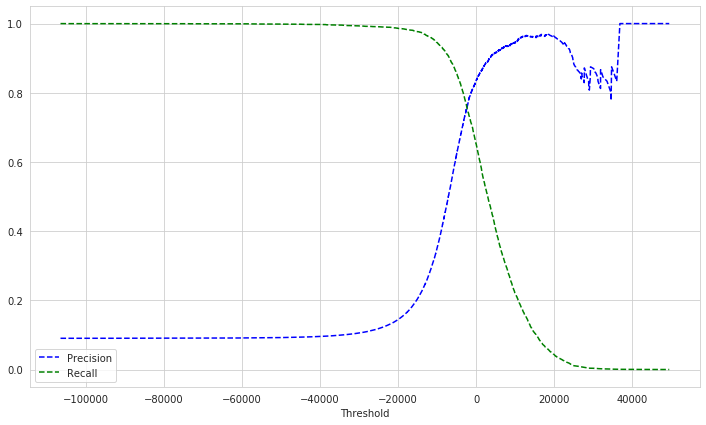

In [42]:
plot_p_r_vs_t(precisions, recalls, thresholds)
plt.show()

Text(0, 0.5, 'Precision')

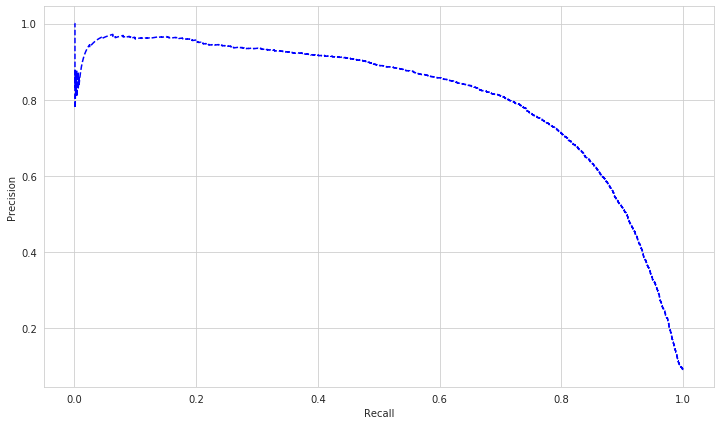

In [43]:
plt.figure(figsize=(12,7))
plt.plot(recalls[:-1],precisions[:-1],"b--")
plt.xlabel("Recall")
plt.ylabel("Precision")

In [44]:
# We can see a sharp decline at 80% recall of the precision, so it'd be interesting to put the threshold before, like at 60%.

In [45]:
threshold_90_precision = thresholds[np.argmax(precisions >=0.90)]

In [46]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [47]:
print(precision_score(y_train_5,y_train_pred_90)) #here we are with a 90% precision classifier!
print(recall_score(y_train_5,y_train_pred_90)) #but the recall is very low...

0.9000345901072293
0.4799852425751706


In [48]:
#Using the Sklearn visualization API...
from scikitplot.metrics import plot_confusion_matrix,plot_precision_recall,plot_roc_curve

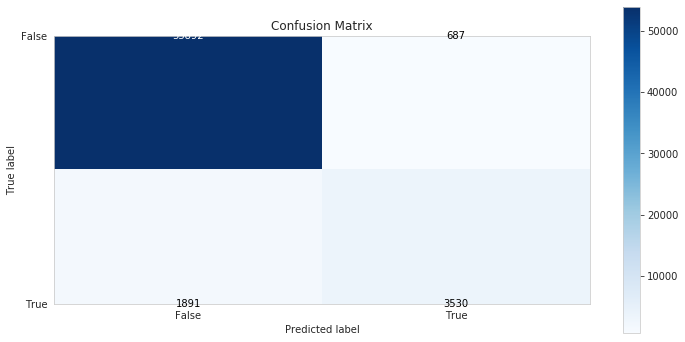

In [49]:
plot_confusion_matrix(y_train_5,y_train_predict,figsize=(12,6))
plt.show()

In [50]:
from sklearn.metrics import roc_curve

In [51]:
fpr , tpr, thresholds = roc_curve(y_train_5,y_scores)

In [52]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.figure(figsize=(12,8))
    plt.plot(fpr,tpr,linewidth = 2,label=label)
    plt.plot([0,1],[0,1],"k--") #Dashed diagonal
    plt.ylabel("True Positive Rate (FPR) / Recall / Sensitivity")
    plt.xlabel("True Negative Rate (FPR) /1- Specificity")
    plt.legend()

No handles with labels found to put in legend.


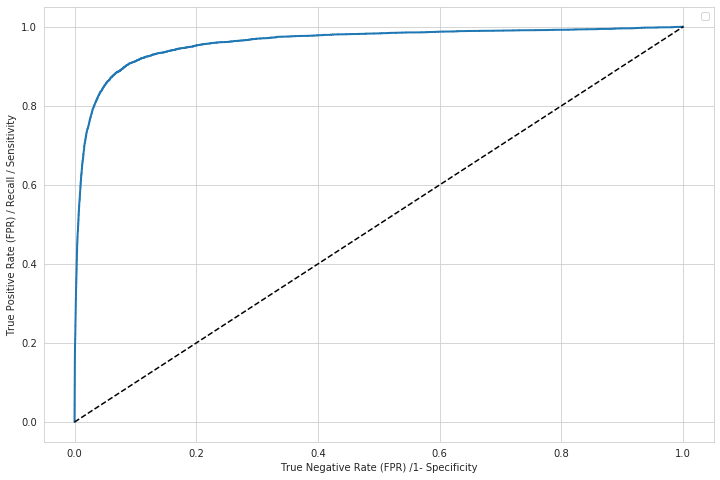

In [53]:
plot_roc_curve(fpr , tpr)
plt.show()

In [54]:
from sklearn.metrics import roc_auc_score

In [55]:
roc_auc_score(y_train_5,y_scores) #Area under the ROC ! a perfect classifier would have a AUC of 1.

0.9604938554008616

If positive class is rare and / or we care more about the false positives than false negative then we should use the PR curve. Otherwise we should use the ROC curve.

In [56]:
from sklearn.ensemble import RandomForestClassifier

In [57]:
forest_clf = RandomForestClassifier(n_jobs=-1,random_state=42)

In [58]:
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method="predict_proba")

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [59]:
y_scores_forest = y_probas_forest[:,1] #Proba of positive class
fpr_forest,tpr_forest,thresholds_forest = roc_curve(y_train_5,y_scores_forest)

<Figure size 864x432 with 0 Axes>

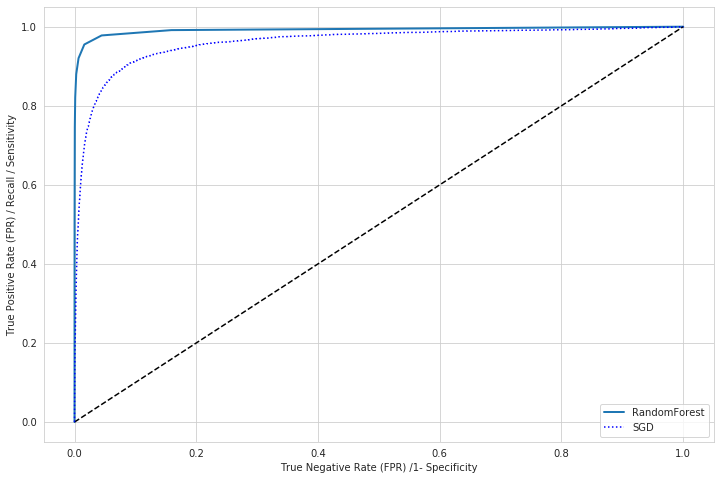

In [60]:
plt.figure(figsize=(12,6))
plot_roc_curve(fpr_forest,tpr_forest,"RandomForest")
plt.plot(fpr,tpr,"b:",label="SGD")
plt.legend(loc="lower right")
plt.show()

In [61]:
roc_auc_score(y_train_5,y_scores_forest) #Area under the ROC ! a perfect classifier would have a AUC of 1.

0.9920527492698306

In [62]:
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5,y_scores_forest)

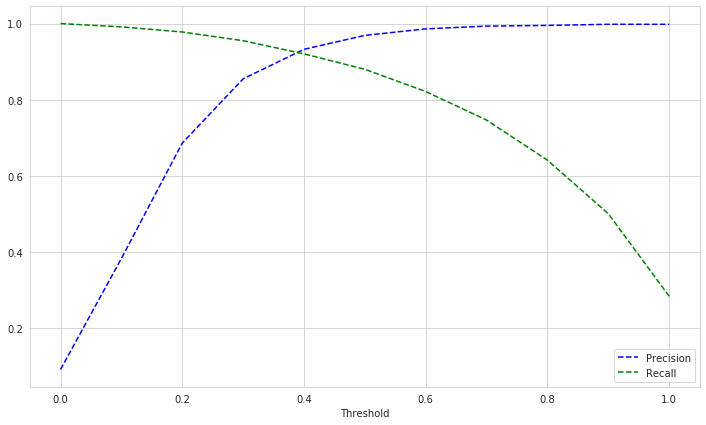

In [63]:
plot_p_r_vs_t(precisions_forest, recalls_forest, thresholds_forest)
plt.show()

In [64]:
print(precision_score(y_train_5,y_scores_forest > 0.4) * 100) #here we are with a 96% precision classifier!
print(recall_score(y_train_5,y_scores_forest > 0.4) * 100) #and with 88% of recall!

96.8915075172694
87.97269876406567


## Multiclass Classification

Multiclass classifiers (also called multinomial classifiers) can distinguish between more than two classes.
It does exist various strategy to perform multiclass classification with multiple binary classifiers:
* **One-versus-the-rest (OvR) also called one-versus-all:** Creating a classifier for each category and taking the one giving the highest decision score for the prediction.
* **One-versus-One strategy:** Training the classifier for each pair of category we want to predict. When we use this strategy, we need to run all the classifiers and see which one wins to most duels to do our prediction.

Some algorithms scale poorly with the size of the training set and it is better to use the OvO because it's faster to train many classifiers on small training sets than a few classifiers on large training sets. But for most binary classification, however, OvR is preferred.

In [65]:
from sklearn.svm import SVC

In [66]:
svc_clf = SVC(gamma="scale")

In [67]:
svc_clf.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [68]:
svc_clf.predict([random_digit])

array([5])

In [69]:
random_digit_scores = svc_clf.decision_function([random_digit])

In [70]:
random_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [71]:
np.argmax(random_digit_scores)

5

In [72]:
svc_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [73]:
svc_clf.classes_[5]

5

In [74]:
from sklearn.multiclass import OneVsRestClassifier

In [75]:
ovr_clf = OneVsRestClassifier(SVC(gamma="scale"))

In [76]:
ovr_clf.fit(X_train,y_train)

OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None,
                                  coef0=0.0, decision_function_shape='ovr',
                                  degree=3, gamma='scale', kernel='rbf',
                                  max_iter=-1, probability=False,
                                  random_state=None, shrinking=True, tol=0.001,
                                  verbose=False),
                    n_jobs=None)

In [77]:
#Training an SGDClassifier is as easy
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([random_digit])

array([3])

In [78]:
sgd_clf.decision_function([random_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [79]:
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring="accuracy")

array([0.87082583, 0.87089354, 0.88628294])

In [80]:
from sklearn.preprocessing import StandardScaler

In [81]:
scaler = StandardScaler()

In [82]:
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [83]:
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring="accuracy")

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.89957009, 0.89344467, 0.89963495])

In [85]:
y_train_pred = cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [86]:
confusion_matrix = confusion_matrix(y_train,y_train_pred)

In [87]:
confusion_matrix

array([[5576,    0,   21,    6,    9,   43,   37,    6,  224,    1],
       [   0, 6398,   38,   23,    4,   44,    4,    8,  213,   10],
       [  26,   27, 5242,   90,   71,   26,   62,   36,  371,    7],
       [  24,   17,  117, 5220,    2,  208,   28,   40,  405,   70],
       [  12,   14,   48,   10, 5192,   10,   36,   26,  330,  164],
       [  28,   15,   33,  166,   55, 4437,   76,   14,  538,   59],
       [  30,   14,   41,    2,   43,   95, 5560,    4,  128,    1],
       [  21,    9,   52,   27,   51,   12,    3, 5693,  188,  209],
       [  17,   63,   46,   90,    3,  125,   25,   10, 5429,   43],
       [  23,   18,   31,   66,  116,   32,    1,  179,  377, 5106]])

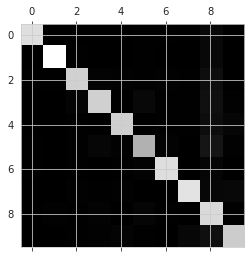

In [88]:
plt.matshow(confusion_matrix,cmap=plt.cm.gray)
plt.show()

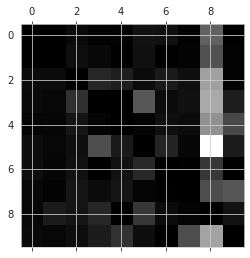

In [89]:
#Comparing in error rate instead of absolute numbers...
row_sums = confusion_matrix.sum(axis=1,keepdims=True)
norm_confusion_matrix = confusion_matrix / row_sums

#Filling diagonal with 0
np.fill_diagonal(norm_confusion_matrix,0)
plt.matshow(norm_confusion_matrix,cmap=plt.cm.gray)
plt.show()

## Multilabel Classification

In [91]:
from sklearn.neighbors import KNeighborsClassifier

In [94]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large,y_train_odd]

In [95]:
knn_clf = KNeighborsClassifier()

In [96]:
knn_clf.fit(X_train,y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [97]:
knn_clf.predict([random_digit])

array([[False,  True]])

In [98]:
y_train_knn_pred = cross_val_predict(knn_clf,X_train,y_multilabel,cv=3)

In [99]:
f1_score(y_multilabel,y_train_knn_pred,average="macro")

0.976410265560605

To give more weight to the classifier's score on one particular label, we can give each label a weight to its support (the number of instances with that target label). To do this, we simply set average="weighted" when we compute the f1 score.

## Multioutput Classification

Multioutput-multiclass classification (multioutput classification) is a generalization of multilabel classification where each label can be multiclass (more than two possible values.)

In [103]:
#Creating a system capable of removing noise from images.
# Output is multilabel (one label per pixel), and each label can have multiple values (pixel intensity).

noise = np.random.randint(0,100,len(X_train),784)
X_train_mod = X_train + noise
noise = np.random.randint(0,100,len(X_train),784)
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

TypeError: data type not understood

In [101]:
knn_clf.fit(X_train_mod,y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[10]])

NameError: name 'X_train_mod' is not defined

In [102]:
plot_digit(clean_digit)

NameError: name 'plot_digit' is not defined

## 1. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the KNeighborsClassifier works quite well for this task; you just need to find good hyperparameter values (try a grid search on the weights and n_neighbors hyperparameters).

## 2. Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel.5 Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called data augmentation or training set expansion.

## 3. Tackle the Titanic dataset. A great place to start is on Kaggle.

## 4. Build a spam classifier (a more challenging exercise):
• Download examples of spam and ham from Apache SpamAssassin’s public
datasets.
• Unzip the datasets and familiarize yourself with the data format.
• Split the datasets into a training set and a test set.
• Write a data preparation pipeline to convert each email into a feature vector.
Your preparation pipeline should transform an email into a (sparse) vector
indicating the presence or absence of each possible word. For example, if all
emails only ever contain four words, “Hello,” “how,” “are,” “you,” then the email
“Hello you Hello Hello you” would be converted into a vector [1, 0, 0, 1]
(meaning [“Hello” is present, “how” is absent, “are” is absent, “you” is
present]), or [3, 0, 0, 2] if you prefer to count the number of occurrences of
each word.
• You may want to add hyperparameters to your preparation pipeline to control
whether or not to strip off email headers, convert each email to lowercase,
remove punctuation, replace all URLs with “URL,” replace all numbers with
“NUMBER,” or even perform stemming (i.e., trim off word endings; there are
Python libraries available to do this).
• Then try out several classifiers and see if you can build a great spam classifier,
with both high recall and high precision.